In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 8.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import time
from datasketch import MinHash, MinHashLSH
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

In [4]:
train_path = '/content/drive/My Drive/big-data-analytics-2025/train.csv'
test_path = '/content/drive/My Drive/big-data-analytics-2025/test_without_labels.csv'

In [5]:
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

In [6]:
train_df.head()

,Id,Title,Content,Label
0,227464,"Netflix is coming to cable boxes, and Amazon i...",if you subscribe to one of three rinky-dink (...,Entertainment
1,244074,"Pharrell, Iranian President React to Tehran 'H...","pharrell, iranian president react to tehran '...",Entertainment
2,60707,Wildlife service seeks comments,the u.s. fish and wildlife service has reopen...,Technology
3,27883,Facebook teams up with Storyful to launch 'FB ...,the very nature of social media means it is o...,Technology
4,169596,Caesars plans US$880 mln New York casino,caesars plans us$880 mln new york casino jul ...,Business


Data Preprocessing

In [7]:
small_train_df = train_df.sample(frac=0.4, random_state=42)
small_test_df = test_df.sample(frac=0.4, random_state=42)
train_df = small_train_df
test_df = small_test_df

In [8]:
print(train_df.shape)
print(test_df.shape)

(44718, 4)
(19165, 3)


In [9]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
def process_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'([.,!?()])', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token)
             for token in tokens
             if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

train_titles = train_df['Title'].apply(process_text)
train_content = train_df['Content'].apply(process_text)
train_text = train_titles + " " + train_content

test_titles = test_df['Title'].apply(process_text)
test_content = test_df['Content'].apply(process_text)
test_text = test_titles + " " + test_content

vectorizer = CountVectorizer(binary=True,max_features=5000)


train_vectors = vectorizer.fit_transform(train_text)
test_vectors = vectorizer.transform(test_text)
train_labels =  train_df['Label'].tolist()


train_vectors_array = train_vectors.toarray()
test_vectors_array = test_vectors.toarray()

In [12]:
def my_jaccard(vec1, vec2):
    intersection = np.logical_and(vec1, vec2).sum()
    union = np.logical_or(vec1, vec2).sum()
    return 1 - (intersection/union if union != 0 else 0)

In [13]:
def compute_minhash_signature(vec, num_permutations):
    minhash = MinHash(num_perm=num_permutations)
    nonzero_elements = vec.nonzero()[1]
    for element in nonzero_elements:
        minhash.update(f"{element}".encode('utf8'))
    return minhash

In [14]:
def initialize_lsh_index(training_vectors, num_permutations, threshold):
    start = time.time()
    lsh_index = MinHashLSH(threshold=threshold, num_perm=num_permutations)

    for doc_idx in range(training_vectors.shape[0]):
        signature = compute_minhash_signature(training_vectors[doc_idx], num_permutations)
        lsh_index.insert(str(doc_idx), signature)

    build_time = (time.time() - start) / 60
    return lsh_index, build_time

In [15]:
def search_similar_vectors(query_vec, lsh_index, training_data, num_permutations, k=7):
    query_signature = compute_minhash_signature(query_vec, num_permutations)
    candidate_matches = lsh_index.query(query_signature)
    candidate_indices = [int(idx) for idx in candidate_matches]

    if candidate_indices:
        similarities = []
        query_array = query_vec.toarray()[0]
        for idx in candidate_indices:
            intersection = np.logical_and(query_array, training_data[idx]).sum()
            union = np.logical_or(query_array, training_data[idx]).sum()
            jaccard_sim = intersection/union if union != 0 else 0
            similarities.append((idx, jaccard_sim))

        return [idx for idx, sim in sorted(similarities, key=lambda x: x[1], reverse=True)[:k]]
    return []

In [16]:
def calculate_accuracy(lsh_results, true_neighbors, k=7):
    correct = 0
    total = 0
    for lsh_nn, actual_nn in zip(lsh_results, true_neighbors):
        if lsh_nn:
            correct += len(set(lsh_nn) & set(actual_nn))
            total += k
    return correct / total if total > 0 else 0

In [17]:
def run_lsh_experiment(train_vectors, train_vectors_array, test_vectors, true_neighbors, num_permutations, threshold):
    print(f"\nRunning experiment with {num_permutations} permutations...")

    # Build index
    lsh_index, build_time = initialize_lsh_index(train_vectors, num_permutations,threshold)

    # Query phase
    query_start = time.time()
    lsh_results = []
    empty_queries = 0

    for i in range(test_vectors.shape[0]):
        top_k = search_similar_vectors(test_vectors[i], lsh_index, train_vectors_array, num_permutations)
        if not top_k:
            empty_queries += 1
        lsh_results.append(top_k)

    query_time = (time.time() - query_start) / 60

    # Calculate accuracy
    accuracy = calculate_accuracy(lsh_results, true_neighbors)

    return {
        'num_permutations': num_permutations,
        'build_time': build_time,
        'query_time': query_time,
        'total_time': build_time + query_time,
        'accuracy': accuracy
    }


In [18]:

permutations = [16, 32, 64]
thresholds = [0.9, 0.8, 0.7, 0.6]
all_results = []

# Get ground truth using brute force
print("Computing ground truth using brute force...")
brute_force_start = time.time()
knn = KNeighborsClassifier(n_neighbors=7, algorithm='brute', metric=my_jaccard)
knn.fit(train_vectors_array, train_labels)
true_neighbors = knn.kneighbors(test_vectors_array, return_distance=False)
brute_force_time = (time.time() - brute_force_start) / 60
print(f"Brute Force Time: {brute_force_time:.2f} minutes")

# Run LSH experiments for each threshold
for threshold in thresholds:
    print(f"\nTesting threshold {threshold}")
    threshold_results = []

    for num_perm in permutations:
        try:
            result = run_lsh_experiment(train_vectors, train_vectors_array, test_vectors,
                                      true_neighbors, num_perm, threshold)
            result['threshold'] = threshold
            threshold_results.append(result)
        except ValueError as e:
            print(f"\nError with {num_perm} permutations and threshold {threshold}: {e}")
            continue

    if threshold_results:
        all_results.extend(threshold_results)


Computing ground truth using brute force...
Brute Force Time: 274.76 minutes

Testing threshold 0.9

Running experiment with 16 permutations...

Error with 16 permutations and threshold 0.9: The number of bands are too small (b < 2)

Running experiment with 32 permutations...

Running experiment with 64 permutations...

Testing threshold 0.8

Running experiment with 16 permutations...

Running experiment with 32 permutations...

Running experiment with 64 permutations...

Testing threshold 0.7

Running experiment with 16 permutations...

Running experiment with 32 permutations...

Running experiment with 64 permutations...

Testing threshold 0.6

Running experiment with 16 permutations...

Running experiment with 32 permutations...

Running experiment with 64 permutations...


In [19]:
for result in all_results:
    print(f"\nThreshold: {result['threshold']}")
    print(f"Permutations: {result['num_permutations']}")
    print(f"Build Time: {result['build_time']:.2f} minutes")
    print(f"Query Time: {result['query_time']:.2f} minutes")
    print(f"Total Time: {result['total_time']:.2f} minutes")
    print(f"Accuracy: {result['accuracy']:.2%}")


Threshold: 0.9
Permutations: 32
Build Time: 1.72 minutes
Query Time: 0.72 minutes
Total Time: 2.44 minutes
Accuracy: 19.10%

Threshold: 0.9
Permutations: 64
Build Time: 1.92 minutes
Query Time: 0.81 minutes
Total Time: 2.73 minutes
Accuracy: 19.23%

Threshold: 0.8
Permutations: 16
Build Time: 1.61 minutes
Query Time: 0.68 minutes
Total Time: 2.29 minutes
Accuracy: 20.72%

Threshold: 0.8
Permutations: 32
Build Time: 1.72 minutes
Query Time: 0.72 minutes
Total Time: 2.44 minutes
Accuracy: 20.54%

Threshold: 0.8
Permutations: 64
Build Time: 1.92 minutes
Query Time: 0.80 minutes
Total Time: 2.72 minutes
Accuracy: 21.14%

Threshold: 0.7
Permutations: 16
Build Time: 1.62 minutes
Query Time: 0.68 minutes
Total Time: 2.29 minutes
Accuracy: 15.28%

Threshold: 0.7
Permutations: 32
Build Time: 1.71 minutes
Query Time: 0.72 minutes
Total Time: 2.43 minutes
Accuracy: 20.09%

Threshold: 0.7
Permutations: 64
Build Time: 1.91 minutes
Query Time: 0.80 minutes
Total Time: 2.71 minutes
Accuracy: 22.48%


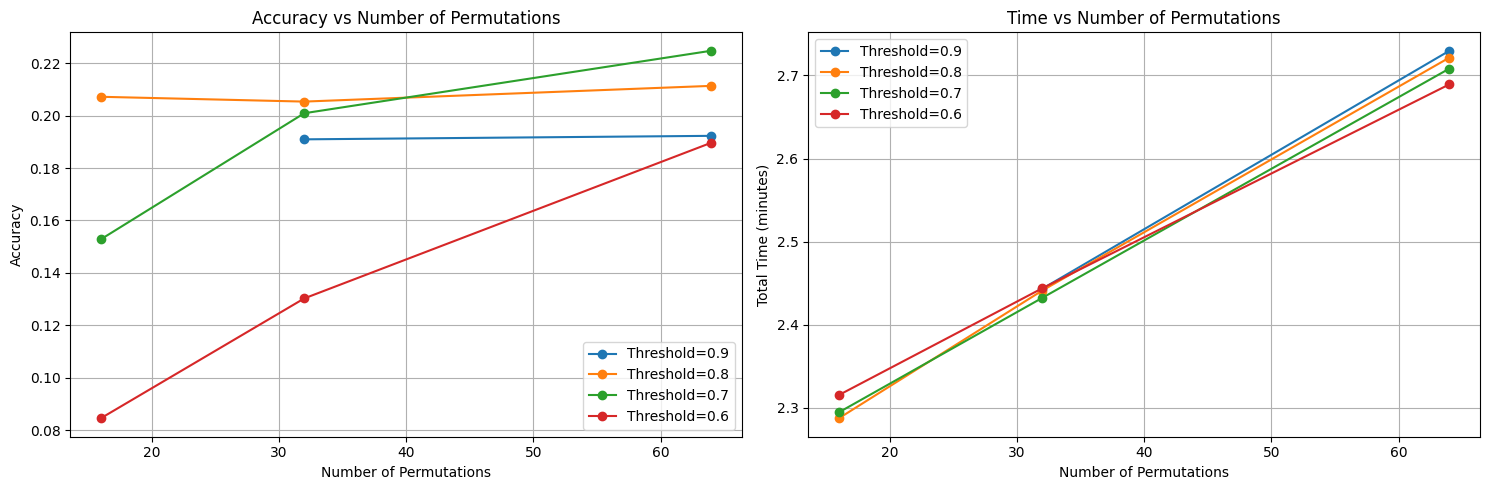

In [20]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(15, 5))

# Group results by threshold
for threshold in thresholds:
    threshold_data = [r for r in all_results if r['threshold'] == threshold]
    if threshold_data:
        perm_counts = [r['num_permutations'] for r in threshold_data]
        accuracies = [r['accuracy'] for r in threshold_data]
        times = [r['total_time'] for r in threshold_data]

        plt.subplot(1, 2, 1)
        plt.plot(perm_counts, accuracies, 'o-', label=f'Threshold={threshold}')
        plt.xlabel('Number of Permutations')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs Number of Permutations')
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(perm_counts, times, 'o-', label=f'Threshold={threshold}')
        plt.xlabel('Number of Permutations')
        plt.ylabel('Total Time (minutes)')
        plt.title('Time vs Number of Permutations')
        plt.grid(True)
        plt.legend()

plt.tight_layout()
plt.show()